In [2]:
import dataclasses
from collections.abc import Iterator, Mapping
from types import MappingProxyType
from typing import Any, Literal, Optional

import jax
import jax.numpy as jnp
import sklearn
import sklearn.datasets

import optax

import matplotlib.pyplot as plt
from IPython.display import clear_output, display

from ott import datasets
from ott.geometry import costs, pointcloud

from ott.tools import sinkhorn_divergence

import jax
import jax.numpy as jnp
from ott.geometry.geometry import Geometry
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
import scipy
import numpy as np

from typing import Any, Optional

import matplotlib.pyplot as plt
from matplotlib import colors

from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem, potentials
from ott.solvers import linear
from ott.tools import progot
import scipy

import pandas as pd
import scanpy as sc
import numpy as np
import torch
import sys
sys.path.insert(0, '../src/')
import importlib
import FRLC
from FRLC import FRLC_opt
import HR_OT
importlib.reload(HR_OT)

import torch.multiprocessing as mp


In [3]:
@jax.jit
def sinkhorn_loss(
    x: jnp.ndarray, y: jnp.ndarray, epsilon: float = 0.001
) -> float:
    """Computes transport between (x, a) and (y, b) via Sinkhorn algorithm."""
    a = jnp.ones(len(x)) / len(x)
    b = jnp.ones(len(y)) / len(y)
    
    _, out = sinkhorn_divergence.sinkhorn_divergence(
        pointcloud.PointCloud, x, y, epsilon=epsilon, a=a, b=b
    )
    
    return out.divergence


def run_progot(
    x: jnp.ndarray, y: jnp.ndarray, cost_fn: costs.TICost, **kwargs: Any
) -> progot.ProgOTOutput:
    geom = pointcloud.PointCloud(x, y, cost_fn=cost_fn)
    prob = linear_problem.LinearProblem(geom)
    estim = progot.ProgOT(**kwargs)
    out = estim(prob)
    return out

K = 4
cost_fn = costs.SqEuclidean()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'On device: {device}')

dtype = torch.float64


On device: cuda


In [6]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
import torch
import torchvision.models as models
import os

In [7]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for CNN input
    transforms.ToTensor(),
])

# Load ImageNet dataset from extracted path # /ILSVRC/Data/CLS-LOC/test
imagenet_dataset = datasets.ImageFolder(root="/scratch/gpfs/DATASETS/imagenet/ilsvrc_2012_classification_localization/train",
                                        transform=transform)

# Create DataLoader for batching
imagenet_loader = DataLoader(imagenet_dataset, batch_size=32, shuffle=True, num_workers=4)

print(f"Loaded {len(imagenet_dataset)} images from ImageNet!")

'''
n_subset = 1000000
subset_indices = np.random.choice(len(imagenet_dataset), n_subset, replace=False)
subset_dataset = Subset(imagenet_dataset, subset_indices)

subset_loader = DataLoader(subset_dataset, batch_size=32, shuffle=True, num_workers=4)
print(f"Loaded {len(subset_dataset)} subset of images from ImageNet!")
'''

'\nn_subset = 1000000\nsubset_indices = np.random.choice(len(imagenet_dataset), n_subset, replace=False)\nsubset_dataset = Subset(imagenet_dataset, subset_indices)\n\nsubset_loader = DataLoader(subset_dataset, batch_size=32, shuffle=True, num_workers=4)\nprint(f"Loaded {len(subset_dataset)} subset of images from ImageNet!")\n'

In [8]:
'''
!mkdir -p ~/.cache/torch/hub/checkpoints
!mv /home/ph3641/HierarchicalRefinement/HR_OT/HR_OT/notebooks/resnet50-0676ba61.pth ~/.cache/torch/hub/checkpoints/
'''

'\n!mkdir -p ~/.cache/torch/hub/checkpoints\n!mv /home/ph3641/HierarchicalRefinement/HR_OT/HR_OT/notebooks/resnet50-0676ba61.pth ~/.cache/torch/hub/checkpoints/\n'

In [9]:
#!ls ~/.cache/torch/hub/checkpoints/

In [10]:

#model_path = "~/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth"
model_path = os.path.expanduser("~/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth")

# Load pretrained ResNet model
model = models.resnet50()
model.load_state_dict(torch.load(model_path, map_location="cpu"))
model.fc = torch.nn.Identity()  # Remove classification layer to extract features
model.eval()  # Set to evaluation mode

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Compute embeddings
def extract_features(dataloader, model):
    embeddings = []
    num_img = 0
    with torch.no_grad():
        for idx, (images, _) in enumerate(dataloader):
            num_img += len(images)
            if idx % 100 == 0:
                print(f'image idx {idx}, images: {num_img}')
            images = images.to(device)
            features = model(images)
            embeddings.append(features.cpu().numpy())
    return np.vstack(embeddings)  # Stack all embeddings

print('extracting embeddings!')
embeddings = extract_features(imagenet_loader, model)

print(embeddings.shape)

'\n#model_path = "~/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth"\nmodel_path = os.path.expanduser("~/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth")\n\n# Load pretrained ResNet model\nmodel = models.resnet50()\nmodel.load_state_dict(torch.load(model_path, map_location="cpu"))\nmodel.fc = torch.nn.Identity()  # Remove classification layer to extract features\nmodel.eval()  # Set to evaluation mode\n\n# Move model to GPU if available\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nmodel.to(device)\n\n# Compute embeddings\ndef extract_features(dataloader, model):\n    embeddings = []\n    num_img = 0\n    with torch.no_grad():\n        for idx, (images, _) in enumerate(dataloader):\n            num_img += len(images)\n            if idx % 100 == 0:\n                print(f\'image idx {idx}, images: {num_img}\')\n            images = images.to(device)\n            features = model(images)\n            embeddings.append(features.cpu().numpy())\n    return

In [11]:

import pickle
save_dir = "/scratch/gpfs/ph3641/hr_ot/"

os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "embeddings.pkl")

with open(save_path, "wb") as f:
    pickle.dump(embeddings, f)

print(f"Embeddings saved successfully to {save_path}")

'\nimport pickle\nsave_dir = "/scratch/gpfs/ph3641/hr_ot/"\n\nos.makedirs(save_dir, exist_ok=True)\nsave_path = os.path.join(save_dir, "embeddings.pkl")\n\nwith open(save_path, "wb") as f:\n    pickle.dump(embeddings, f)\n\nprint(f"Embeddings saved successfully to {save_path}")\n'

In [12]:
import pickle
emb_dir = '/scratch/gpfs/ph3641/hr_ot/embeddings.pkl'

# Load embeddings from the pickle file
with open(emb_dir, "rb") as f:
    embeddings = pickle.load(f)

print(f"Embeddings loaded successfully! Shape: {embeddings.shape}")

Embeddings loaded successfully! Shape: (1281167, 2048)


In [13]:
import rank_annealing

# 1. Making it even, remove 1 image
embeddings = embeddings[1:,:]

# 2. Get to a close even number which when divided is non-prime
print(f'num embeddings: {embeddings.shape[0]}')
N = embeddings.shape[0] // 2
q = 640500
k = (N-q)*2

embed_sliced = embeddings[:-k]
n = embed_sliced.shape[0] // 2
print(n)

rank_schedule = rank_annealing.optimal_rank_schedule( n , hierarchy_depth = 6, max_Q = int(2**11), max_rank = 64 )
print(rank_schedule)


num embeddings: 1281166
640500
Optimized rank-annealing schedule: [7, 50, 1830]
[7, 50, 1830]


In [14]:
import torch

num_samples = embed_sliced.shape[0]

# Shuffle indices
indices = torch.randperm(num_samples)

# Split into two tensors
X = embeddings[indices[:n]]  # First 50%
Y = embeddings[indices[n:]]  # Second 50%

print(f"X shape: {X.shape}, Y shape: {Y.shape}")

X shape: (640500, 2048), Y shape: (640500, 2048)


In [15]:
num_zero_rows = torch.sum(torch.sum(torch.tensor(embeddings), dim=1) == 0).item()
print(f"Number of all-zero rows: {num_zero_rows}")

Number of all-zero rows: 0


In [35]:
import math
import functools
import operator
import rank_annealing
importlib.reload(rank_annealing)
importlib.reload(HR_OT)

# Squared Euclidean cost p=2 or Euclidean if p=1
p = 1
K = 2

#sample_sizes = [int(2**i) for i in range(5, 18, 1)]

# Initialize dictionaries to store costs and sample sizes
costs = {
    'HROT_LR': {'samples': [], 'costs': []},
    'Sinkhorn': {'samples': [], 'costs': []},
    'ProgOT': {'samples': [], 'costs': []}
}

# Define pairwise Dist Mat
_X = torch.tensor(np.array(X)).float().to(device)
_Y = torch.tensor(np.array(Y)).float().to(device)

# hierarchy_depth=6, max_Q=int(2**10), max_rank=16 up to 131072 points
# hierarchy_depth=6, max_Q=int(2**10), max_rank=64 for 262144 + 524288 points
# hierarchy_depth=6, max_Q=int(2**10), max_rank=64 for 262144 + 524288 points
rank_schedule = rank_annealing.optimal_rank_schedule( X.shape[0] , hierarchy_depth = 6, max_Q = int(2**11), max_rank = 64 )
print(rank_schedule)

try:
    hrot_lr = HR_OT.HierarchicalRefinementOT.init_from_point_clouds(_X, _Y, rank_schedule, base_rank=1, device=device)
    del _X, _Y
    F = hrot_lr.run(return_as_coupling=False)
    cost_hrot_lr = hrot_lr.compute_OT_cost()
    print(f'HR-OT cost: {cost_hrot_lr}')
except Exception as e:
    print(f'HROT-LR failed for sample size {n}: {e}')


Optimized rank-annealing schedule: [7, 50, 1830]
[7, 50, 1830]
x0 shape: torch.Size([640500, 2048]), x1 shape: torch.Size([640500, 2048]), rankD: 7
Iteration: 0
x0 shape: torch.Size([91500, 2048]), x1 shape: torch.Size([91500, 2048]), rankD: 50
Iteration: 0
x0 shape: torch.Size([91500, 2048]), x1 shape: torch.Size([91500, 2048]), rankD: 50
Iteration: 0
x0 shape: torch.Size([91500, 2048]), x1 shape: torch.Size([91500, 2048]), rankD: 50
Iteration: 0
x0 shape: torch.Size([91500, 2048]), x1 shape: torch.Size([91500, 2048]), rankD: 50
Iteration: 0
x0 shape: torch.Size([91500, 2048]), x1 shape: torch.Size([91500, 2048]), rankD: 50
Iteration: 0
x0 shape: torch.Size([91500, 2048]), x1 shape: torch.Size([91500, 2048]), rankD: 50
Iteration: 0
x0 shape: torch.Size([91500, 2048]), x1 shape: torch.Size([91500, 2048]), rankD: 50
Iteration: 0
Last level, rank chunk-size 1830 with 350 iterations to completion.
0/350 of final-level iterations to completion
x0 shape: torch.Size([1830, 2048]), x1 shape: 

In [37]:
n = len(F)
mat = np.zeros((n, 2))

for k, (idx1, idx2) in enumerate(F):
    mat[k, 0] = idx1.cpu().numpy()
    mat[k, 1] = idx2.cpu().numpy()

np.save('/scratch/gpfs/ph3641/hr_ot/embedding_alignment.npy', mat)

/tmp/ipykernel_3377641/4293063376.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat[k, 0] = idx1.cpu().numpy()
/tmp/ipykernel_3377641/4293063376.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat[k, 1] = idx2.cpu().numpy()


In [15]:
mat = np.load('/scratch/gpfs/ph3641/hr_ot/embedding_alignment.npy')
print(mat.shape)

(640500, 2)


In [16]:
!pip install umap-learn

In [ ]:

import umap
import numpy as np
import torch
import matplotlib.pyplot as plt

# Convert to NumPy if using PyTorch
if isinstance(X, torch.Tensor):
    X = X.cpu().numpy()
if isinstance(Y, torch.Tensor):
    Y = Y.cpu().numpy()

# Combine X and Y
combined = np.vstack([X, Y])  # Shape (2M, d)

from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=2)
combined_2d = pca.fit_transform(combined)

# Split back into X and Y
X_2d = combined_2d[:N]
Y_2d = combined_2d[N:]

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(X_2d[:, 0], X_2d[:, 1], color='red', alpha=0.6, label='X')
plt.scatter(Y_2d[:, 0], Y_2d[:, 1], color='blue', alpha=0.6, label='Y')
plt.title("PCA Visualization of X and Y")
plt.legend()
plt.show()


Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 0.0002204796764999628, GW-cost: 0, Total cost: 0.0002204796764999628
Final Wasserstein cost: 0.00020263154874555767, GW-cost: 0, Total cost: 0.00020263154874555767


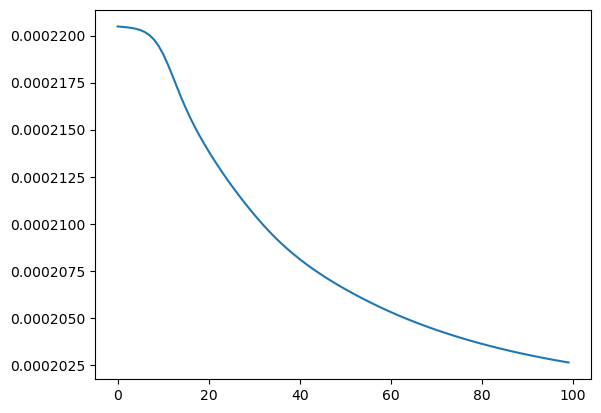

FRLC cost: 24.119528396607183


In [20]:
import ott
from ott.geometry import pointcloud, geometry
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn, sinkhorn_lr
import torch
import FRLC
import util
'''
# Does not run
#geom_xy = ott.geometry.geometry.Geometry(cost_matrix=C.cpu().numpy()) 
geom_xy = pointcloud.PointCloud(X, Y, cost_fn=ott.geometry.costs.Euclidean()) # only runs first pair of datasets

ot_prob = linear_problem.LinearProblem(geom_xy)
solver = sinkhorn_lr.LRSinkhorn(rank=40)
ot_lr = solver(ot_prob)
cost_lot = ot_lr.primal_cost
print(f'cost: {cost_lot:.4f}')
'''

'''
_X, _Y = torch.tensor(X).to(device), torch.tensor(Y).to(device)

C1, C2 = util.low_rank_distance_factorization(_X, _Y, r=40, eps=0.04, device=device)
# Normalize appropriately
c = ( C1.max()**1/2 ) * ( C2.max()**1/2 )
C1, C2 = C1/c, C2/c
C_factors = (C1.to(_X.dtype), C2.to(_X.dtype))

Q, R, diagG, errs = FRLC.FRLC_LR_opt(C_factors,
                                     A_factors=None, 
                                     B_factors=None,
                                   gamma=30,
                                   r = 40,
                                   max_iter=200,
                                   device=device,
                                   min_iter = 100,
                                   max_inneriters_balanced=100,
                                   max_inneriters_relaxed=40,
                                   diagonalize_return=True,
                                   printCost=True, tau_in=100000,
                                    dtype = _X.dtype)

print(f'FRLC cost: {errs['W_cost'][-1] * c**2}')'''

In [ ]:
import numpy as np
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


'''
def tsne_alignment_plot(X, Y, match_lines=True, perplexity=30, random_state=42):
    """
    Visualize alignment of two embedding sets X and Y in 2D t-SNE space.
    
    Args:
        X (np.ndarray or torch.Tensor): Embeddings of shape (N, d).
        Y (np.ndarray or torch.Tensor): Embeddings of shape (N, d).
        match_lines (bool): If True, draw lines between matched pairs.
        perplexity (int): t-SNE perplexity (affects clustering).
        random_state (int): Seed for reproducibility.
    """

    # Convert to NumPy if using PyTorch
    if isinstance(X, torch.Tensor):
        X = X.cpu().numpy()
    if isinstance(Y, torch.Tensor):
        Y = Y.cpu().numpy()
    
    N = X.shape[0]  # number of points in each set
    
    # 1) Combine embeddings
    combined = np.vstack([X, Y])  # shape (2N, d)
    
    # 2) Apply t-SNE to the combined embeddings
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
    combined_2d = tsne.fit_transform(combined)  # shape (2N, 2)
    
    # 3) Split back into X and Y
    X_2d = combined_2d[:N]     # first N rows
    Y_2d = combined_2d[N:]     # last N rows
    
    # 4) Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], color='red',  alpha=0.6, label='X')
    plt.scatter(Y_2d[:, 0], Y_2d[:, 1], color='blue', alpha=0.6, label='Y')
    
    # Optionally draw lines between matched pairs
    if match_lines:
        for i in range(N):
            plt.plot(
                [X_2d[i, 0], Y_2d[i, 0]],
                [X_2d[i, 1], Y_2d[i, 1]],
                color='gray', alpha=0.5, linewidth=0.5
            )
    
    plt.title("t-SNE Visualization of X and Y")
    plt.legend()
    plt.show()

tsne_alignment_plot(X, Y, match_lines=False, perplexity=30, random_state=42)
'''